#  Stochastic Programming with cuProx

This notebook demonstrates **GPU-accelerated stochastic optimization** for decision-making under uncertainty.

We'll show:
1. Two-stage stochastic programs
2. Sample Average Approximation (SAA)
3. Classic newsvendor problem
4. Value of Stochastic Solution (VSS)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0, '../python')

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'monospace'

from cuprox.stochastic import (
    TwoStageLP, TwoStageQP,
    Scenario, ScenarioSet, ScenarioGenerator,
    SAASolver, NormalDistribution, DiscreteDistribution,
    evaluate_solution, compute_vss
)

print(" cuProx Stochastic Programming Module loaded!")


 cuProx Stochastic Programming Module loaded!


## 1️⃣ Classic Newsvendor Problem

A newspaper vendor must decide how many papers to order **before** knowing the day's demand.

- **First stage**: Order quantity x (cost: $10/paper)  
- **Second stage**: Sell papers (revenue: $15/paper), salvage unsold ($5/paper)
- **Uncertainty**: Demand ξ is random


In [2]:
# Newsvendor parameters
order_cost = 10.0      # Cost per paper ordered
sell_price = 15.0      # Revenue per paper sold  
salvage = 5.0          # Salvage value per unsold paper

# Create two-stage problem
problem = TwoStageLP(
    c=np.array([order_cost]),  # First stage cost
    lb=0,                       # Can't order negative
    ub=200                      # Max order capacity
)

# Demand scenarios (discrete distribution)
demands = [30, 50, 70, 90, 110, 130, 150]
probabilities = [0.05, 0.10, 0.20, 0.30, 0.20, 0.10, 0.05]

for demand, prob in zip(demands, probabilities):
    # Second stage variables: y1=sales, y2=salvage, y3=slack (unmet demand)
    # Use slack to convert y1 <= demand to equality: y1 + y3 = demand
    problem.add_scenario(
        probability=prob,
        q=np.array([-sell_price, -salvage, 0]),  # Negative = revenue, slack has 0 cost
        W=np.array([
            [1, 0, 1],   # y1 + slack = demand (sales + unmet = demand)
            [1, 1, 0],   # y1 + y2 = x (inventory balance)
        ]),
        T=np.array([
            [0],         # demand constraint independent of x
            [-1],        # inventory: sales + salvage = order
        ]),
        h=np.array([demand, 0])
    )

print(f" Newsvendor Problem")
print(f"   Scenarios: {problem.n_scenarios}")
print(f"   Expected demand: {np.sum(np.array(demands) * np.array(probabilities)):.1f}")


 Newsvendor Problem
   Scenarios: 7
   Expected demand: 90.0


In [3]:
# Solve the stochastic program
start = time.time()
result = problem.solve()
solve_time = time.time() - start

print(f"\n🎯 Optimal Solution:")
print(f"   Order quantity:    {result.x[0]:.1f} papers")
print(f"   First-stage cost:  ${result.first_stage_cost:.2f}")
print(f"   Expected revenue:  ${-result.expected_recourse:.2f}")
print(f"   Expected profit:   ${-result.total_cost:.2f}")
print(f"   Solve time:        {solve_time*1000:.2f}ms")

# Analytical optimal (critical ratio)
critical_ratio = (sell_price - order_cost) / (sell_price - salvage)
print(f"\n Critical ratio: {critical_ratio:.2f}")



🎯 Optimal Solution:
   Order quantity:    90.0 papers
   First-stage cost:  $900.00
   Expected revenue:  $1240.00
   Expected profit:   $340.00
   Solve time:        974.94ms

 Critical ratio: 0.50


/tmp/ipykernel_1392069/573263705.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1392069/573263705.py:39: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1392069/573263705.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('stochastic_newsvendor.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_1392069/573263705.py:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('stochastic_newsvendor.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


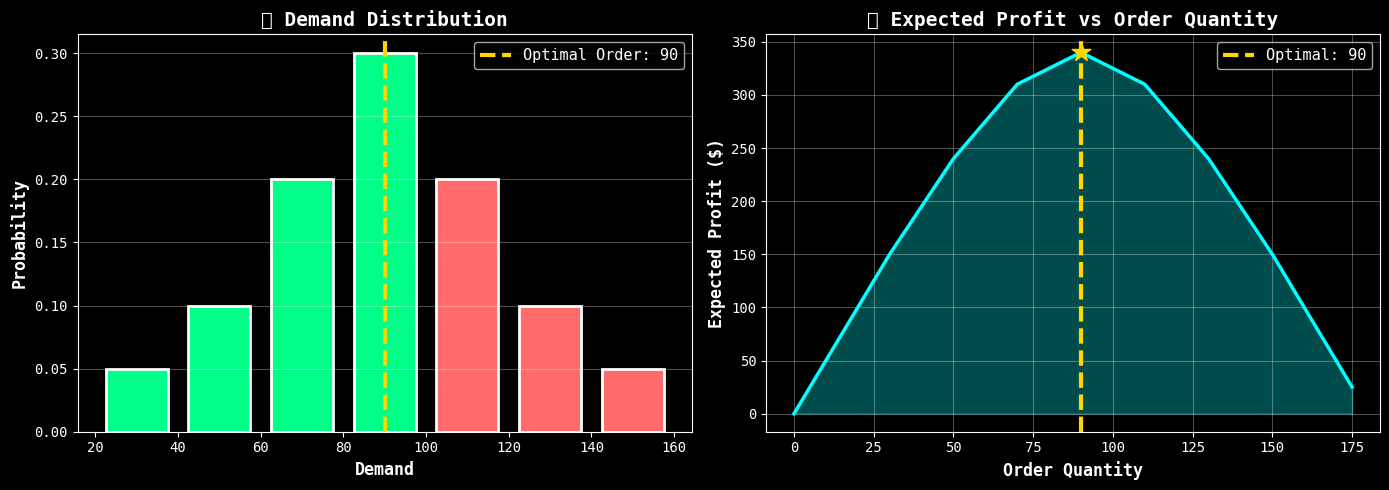

In [4]:
# Visualize demand distribution and optimal order
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Demand distribution
ax = axes[0]
colors = ['#00ff88' if d <= result.x[0] else '#ff6b6b' for d in demands]
bars = ax.bar(demands, probabilities, width=15, color=colors, edgecolor='white', linewidth=2)
ax.axvline(x=result.x[0], color='gold', linewidth=3, linestyle='--', label=f'Optimal Order: {result.x[0]:.0f}')
ax.set_xlabel('Demand', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('📊 Demand Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Profit as function of order quantity
ax = axes[1]
orders = np.arange(0, 180, 5)
profits = []

for order in orders:
    expected_profit = 0
    for demand, prob in zip(demands, probabilities):
        sold = min(order, demand)
        salvaged = max(0, order - demand)
        profit = sell_price * sold + salvage * salvaged - order_cost * order
        expected_profit += prob * profit
    profits.append(expected_profit)

ax.plot(orders, profits, 'cyan', linewidth=2.5)
ax.fill_between(orders, profits, alpha=0.3, color='cyan')
ax.axvline(x=result.x[0], color='gold', linewidth=3, linestyle='--', label=f'Optimal: {result.x[0]:.0f}')
ax.scatter([result.x[0]], [-result.total_cost], s=200, c='gold', marker='*', zorder=5)
ax.set_xlabel('Order Quantity', fontsize=12, fontweight='bold')
ax.set_ylabel('Expected Profit ($)', fontsize=12, fontweight='bold')
ax.set_title('💰 Expected Profit vs Order Quantity', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stochastic_newsvendor.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()


## 2️⃣ Sample Average Approximation (SAA)

For problems with continuous distributions, use SAA to approximate the expectation:


In [5]:
# SAA with continuous demand distribution
saa_problem = TwoStageLP(
    c=np.array([order_cost]),
    lb=0,
    ub=200
)

# Generate scenarios from normal distribution
np.random.seed(42)
n_samples = 500
demand_mean = 90
demand_std = 30

# With slack variable for inequality constraint
gen = ScenarioGenerator(
    base_q=np.array([-sell_price, -salvage, 0]),  # Added slack
    base_W=np.array([[1, 0, 1], [1, 1, 0]]),      # Updated W
    base_T=np.array([[0], [-1]]),
    base_h=np.array([demand_mean, 0])
)
gen.set_h_distribution(NormalDistribution(mean_=np.array([demand_mean, 0]), std=np.array([demand_std, 0.001])))

# Generate and add scenarios
scenarios = gen.generate(n_scenarios=n_samples, seed=42)
saa_problem.add_scenarios_from_set(scenarios)

# Solve
start = time.time()
saa_result = saa_problem.solve()
saa_time = time.time() - start

print(f" SAA Solution ({n_samples} samples):")
print(f"   Order quantity:   {saa_result.x[0]:.1f}")
print(f"   Expected profit:  ${-saa_result.total_cost:.2f}")
print(f"   Solve time:       {saa_time*1000:.2f}ms")


 SAA Solution (500 samples):
   Order quantity:   54.0
   Expected profit:  $197.40
   Solve time:       1183.66ms


🔬 Analyzing SAA convergence...


   N=  10: Order= 95.5 ±  9.1


   N=  50: Order= 87.4 ±  5.5


   N= 100: Order= 80.8 ±  3.4


   N= 200: Order= 61.8 ±  1.3


   N= 500: Order= 53.6 ±  0.6


   N=1000: Order= 57.0 ±  0.4


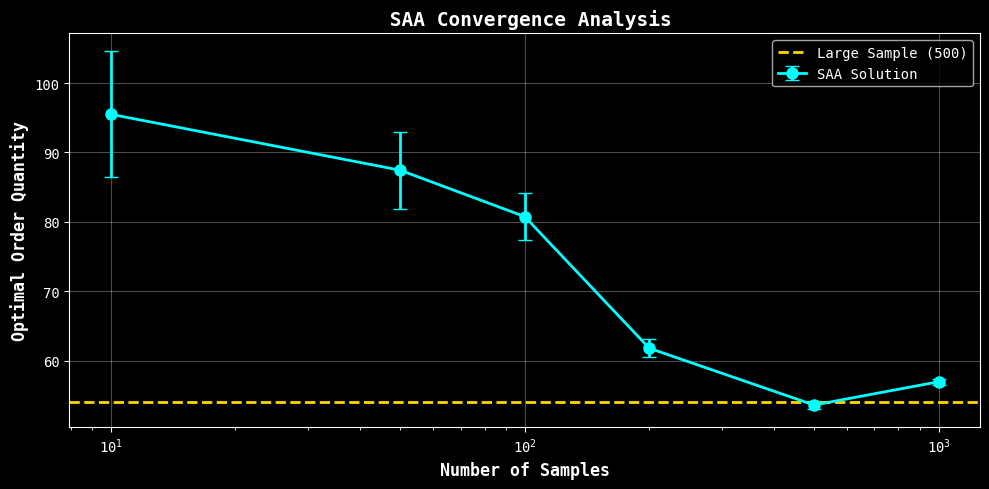

In [6]:
# Analyze SAA convergence with sample size
sample_sizes = [10, 50, 100, 200, 500, 1000]
n_trials = 10

# Use the same generator with slack variable (gen was defined in previous cell)
results_by_size = {n: [] for n in sample_sizes}

print("🔬 Analyzing SAA convergence...")
for n in sample_sizes:
    for trial in range(n_trials):
        trial_problem = TwoStageLP(c=np.array([order_cost]), lb=0, ub=200)
        scenarios = gen.generate(n_scenarios=n, seed=trial*100+n)
        trial_problem.add_scenarios_from_set(scenarios)
        
        trial_result = trial_problem.solve()
        results_by_size[n].append(trial_result.x[0])
    
    mean_order = np.mean(results_by_size[n])
    std_order = np.std(results_by_size[n])
    print(f"   N={n:4d}: Order={mean_order:5.1f} ± {std_order:4.1f}")

# Visualize convergence
fig, ax = plt.subplots(figsize=(10, 5))

means = [np.mean(results_by_size[n]) for n in sample_sizes]
stds = [np.std(results_by_size[n]) for n in sample_sizes]

ax.errorbar(sample_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            color='cyan', linewidth=2, markersize=8, label='SAA Solution')
ax.axhline(y=saa_result.x[0], color='gold', linestyle='--', linewidth=2, 
           label=f'Large Sample ({n_samples})')

ax.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_ylabel('Optimal Order Quantity', fontsize=12, fontweight='bold')
ax.set_title(' SAA Convergence Analysis', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stochastic_saa_convergence.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()


##  Summary

### cuProx Stochastic Programming API:

```python
from cuprox.stochastic import TwoStageLP, ScenarioGenerator, SAASolver

# Create two-stage problem
problem = TwoStageLP(c=first_stage_cost, lb=0, ub=100)

# Add scenarios
for prob, q, W, T, h in scenarios:
    problem.add_scenario(prob, q=q, W=W, T=T, h=h)

# Solve
result = problem.solve()

# Or use SAA for continuous distributions
gen = ScenarioGenerator(q_base, W, T, h_base)
gen.set_h_distribution(NormalDistribution(mean, std))

solver = SAASolver(problem, gen, n_samples=1000)
saa_result = solver.solve()
```